In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# Clustering on Samples

The goal of sample-based clustering is to find the phenotype structures or substructures of the samples. Previous studies have demonstrated that phenotypes of samples can be discriminated through only a small subset of genes whose expression levels strongly correlate with the class distinction. These genes are called informative genes. The remaining genes in the gene expression matrix are irrelevant to the division of samples of interest and thus are regarded as noise in the data set.

The existing methods of selecting informative genes to cluster samples fall into two major categories: **supervised analysis** (clustering based on supervised informative gene selection) and **unsupervised analysis** (unsupervised clustering and informative gene selection).


**Note** : Since we have ground truth labels available, we can assess the quality of clustering. For the tasks at hand we would use entropy to measure cluster goodness. This will help us compare different clustering methods. 

In [2]:
def entropy(clusterlabels, y):
    
    N = clusterlabels.shape[0]
    entropy = dict()
    total_entropy = 0
    
    for label in np.unique(clusterlabels):
        
        n = clusterlabels[np.where(clusterlabels==label)].shape[0]
        y_cluster = y[np.where(clusterlabels==label)]
        arr = np.unique(y_cluster, return_counts = True)[1]
        entropy[label] = - np.sum(arr/n * np.log(arr/n))
        total_entropy += entropy[label] * n/N
        
    return entropy,total_entropy
    
    

## Clustering based on supervised informative gene selection

The supervised approach assumes that phenotype information is attached to the samples. Using this information, a “classifier” which only contains the informative genes can be constructed. Based on this “classifier”, samples can be clustered to match their phenotypes and labels can be predicted for the future coming samples from
the expression profiles. The major steps to build the classifier include:

1. ***Training sample selection*** : Divide the dataset into train and test

2. ***Informative gene selection*** : Build a classifier which ranks feature importances and select important features i.e. the informative genes (Week 1)

3. ***Sample clustering and classification*** : After about 50 - 200 informative genes which manifest the phenotype partition within the training samples are selected, the whole set of samples are clustered using only the informative genes as features. Since the feature volume is relatively small, conventional clustering algorithms, such as K-means or SOM, are usually applied to cluster samples.

**Note**: Usually, the number of phenotypes within a gene expression matrix is very small and known in advance. For example, the number of phenotypes is for the well-known leukemia microarray set which often serves as the benchmark for microarray analysis methods. **Thus for sample-based analysis, the number of clusters is always pre-defined, namely, as an input parameter of the clustering method.** In the current dataset, phenotypes are 5 classes of cancer, so we already know the optimal number of clusters, which is equal to 5.  


In [3]:
dfcomplete = pd.read_csv("datasets/cleaned/datacleaned.csv")
df_feature_selection = pd.read_csv("datasets/featureselection/train.csv")

In [4]:
informative_genes = df_feature_selection.columns.to_list()

In [5]:
df_sup = dfcomplete[informative_genes]

In [6]:
X_sup = df_sup.drop(columns=['Class'])
y_sup = df_sup['Class']

In [7]:
X_sup.set_index('sample_id', inplace=True)

In [8]:
X_sup = (X_sup - X_sup.mean()) / X_sup.std()

### KMeans Clustering

In [9]:
kmeans_sup = KMeans(n_clusters=5)

In [10]:
kmeans_sup.fit(X_sup)

KMeans(n_clusters=5)

In [11]:
clusterlabels_kmeans_sup = kmeans_sup.predict(X_sup)

In [12]:
kmeanscluster = pd.DataFrame({"kmeans": clusterlabels_kmeans_sup, "groundtruth":y_sup})

In [13]:
entropy(clusterlabels_kmeans_sup,y_sup.values)

({0: 0.05554607526889177, 1: -0.0, 2: -0.0, 3: -0.0, 4: -0.0},
 0.021011811244037712)

The entropy of each cluster and total entropy of all clusters is close to zero. This means samples have been nearly perfectly clustered. We need to check for cluster 3

In [14]:
ycluster0 = y_sup.values[np.where(clusterlabels_kmeans_sup==0)]
np.unique(ycluster0,return_counts=True)

(array([0, 2], dtype=int64), array([300,   3], dtype=int64))

In [15]:
kmeanscluster[(kmeanscluster.kmeans==0) & (kmeanscluster.groundtruth==2) ]

,kmeans,groundtruth
129,0,2
507,0,2
599,0,2


<AxesSubplot:xlabel='kmeans', ylabel='groundtruth'>

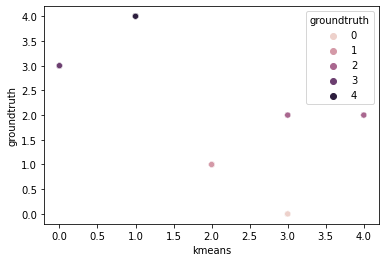

In [30]:
sns.scatterplot(x="kmeans", y="groundtruth", data=kmeanscluster, hue="groundtruth" s = )

In [89]:
kmeanscluster.groupby('kmeans').mean()

,groundtruth
kmeans,
0,0.019802
1,2.000000
2,1.000000
3,3.000000
4,4.000000


Only 3 examples are assigned different cluster, which belonged to the same class. 

### DBScan Clustering

Finding optimal hyperparameters for DBSCAN : One technique to automatically determine the optimal ε value is described in the paper listed below. This technique calculates the average distance between each point and its k nearest neighbors, where k = the MinPts value you selected. The average k-distances are then plotted in ascending order on a k-distance graph. You’ll find the optimal value for ε at the point of maximum curvature (i.e. where the graph has the greatest slope).

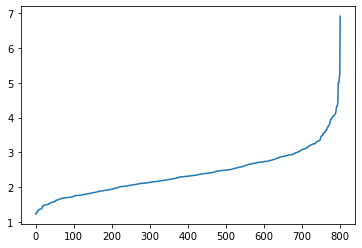

In [16]:
neighbors = NearestNeighbors(n_neighbors=50)
neighbors_fit = neighbors.fit(X_sup)
distances, indices = neighbors_fit.kneighbors(X_sup)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [17]:
entropies_dbscan = []
for epsilon in np.arange(3,6,0.5):
    dbscan = DBSCAN(eps=epsilon,min_samples=50)
    clusterlabels_dbscan_sup = dbscan.fit_predict(X_sup)
    entropies_dbscan.append(entropy(clusterlabels_dbscan_sup, y_sup.values)[1])

In [18]:
entropies_dbscan

[0.4830720263150855,
 0.22369508472804708,
 0.05717620444584738,
 0.013594256870726885,
 0.002808165516198793,
 0.001730704570686505]

In [19]:
dbscan = DBSCAN(eps=5.5, min_samples=50)
clusterlabels_dbscan_sup = dbscan.fit_predict(X_sup)
entropy(clusterlabels_dbscan_sup, y_sup.values)

({-1: 0.6931471805599453, 0: -0.0, 1: -0.0, 2: -0.0, 3: -0.0, 4: -0.0},
 0.001730704570686505)

In [20]:
dbscancluster = pd.DataFrame({"dbscan": clusterlabels_dbscan_sup, "groundtruth":y_sup})

In [21]:
dbscancluster[dbscancluster.dbscan==-1 ]

,dbscan,groundtruth
507,-1,2
789,-1,1


It can be seen that sample number 507, 789 are detected as outliers by dbscan while 507 was also misclustered by kmeans clustering. Overall DBscan performed slightly better than kmeans. 

## Unsupervised clustering and informative gene selection

Unsupervised sample-based clustering assumes no phenotype information being assigned to any sample. Since the initial biological identification of sample classes has been slow, typically evolving through years of hypothesis-driven research, automatically discovering samples’ phenotypes presents a significant contribution in gene expression data analysis 

Two general strategies have been employed to address the problem of unsupervised clustering and information gene selection: unsupervised gene selection and interrelated clustering.

1. **Unsupervised gene selection :** The first strategy differentiates gene selection and sample clustering as independent processes. First the gene (feature) dimension is reduced, then the conventional clustering algorithms are applied. Since no training samples are available, gene selection only relies on statistical models to analyze the variance in the gene expression data. Alter et al. [4] applied the principal component analysis (PCA) to capture the majority of the variations within the genes by a small set of principal components (PCs), called “eigen-genes.” The samples are then projected on the new lower-dimensional PC space.

2. **Interrelated clustering :** strategy utilizes the relationship between the genes and samples to perform gene selection and sample clustering simultaneously in an iterative paradigm. 


For this task we will apply the 1st strategy that is Unsupervised gene selection using PCA components which we elected in week 2. 

### KMeans - PCA

In [23]:
from sklearn.decomposition import PCA

In [34]:
df_dim = dfcomplete.drop(columns=['Class'])
df_dim.set_index("sample_id", inplace = True)
pca = PCA(n_components=250)
df_dim_tr = pca.fit_transform(df_dim)

In [35]:
kmeans_unsup = KMeans(n_clusters=5)
kmeans_unsup.fit(df_dim_tr)
clusterlabels_kmeans_unsup = kmeans_unsup.predict(df_dim_tr)

In [36]:
entropy(clusterlabels_kmeans_unsup,y_sup.values)

({0: -0.0, 1: 0.06184819574705823, 2: -0.0, 3: -0.0, 4: 0.0744466204045084},
 0.03650059524144111)

In [90]:
kmeansclusterpca = pd.DataFrame({"kmeans": clusterlabels_kmeans_unsup, "groundtruth":y_sup})

In [91]:
kmeansclusterpca.groupby('kmeans').mean()

,groundtruth
kmeans,
0,3.000000
1,0.016502
2,4.000000
3,1.000000
4,2.028369


In [92]:
kmeansclusterpca[(kmeansclusterpca.kmeans==1) & (kmeansclusterpca.groundtruth!=0)]

,kmeans,groundtruth
61,1,1
129,1,2
599,1,2


In [93]:
kmeansclusterpca[(kmeansclusterpca.kmeans==4) & (kmeansclusterpca.groundtruth!=2)]

,kmeans,groundtruth
252,4,4
798,4,4


### DBSCAN - PCA

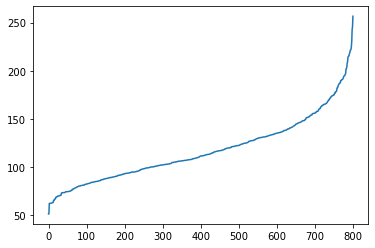

In [43]:
neighborspca = NearestNeighbors(n_neighbors=50)
neighborspca_fit = neighborspca.fit(df_dim_tr)
distances, indices = neighborspca_fit.kneighbors(df_dim_tr)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [57]:
entropies_dbscan_pca = []
for epsilon in np.arange(100,175,5):
    dbscanpca = DBSCAN(eps=epsilon,min_samples=50)
    clusterlabels_dbscan_pca = dbscanpca.fit_predict(df_dim_tr)
    entropies_dbscan_pca.append((epsilon,entropy(clusterlabels_dbscan_pca, y_sup.values)[1]))

In [58]:
sorted(entropies_dbscan_pca, key = lambda x: x[1], reverse = False)[:10]

[(160, 0.2270684894177944),
 (155, 0.266031074837747),
 (150, 0.3390074993764397),
 (145, 0.6001718432908156),
 (140, 0.640833331910165),
 (135, 0.6840082513089288),
 (130, 0.757956511990184),
 (170, 0.7723799347919256),
 (165, 0.7817681356934851),
 (125, 0.8473237725008471)]

In [59]:
dbscanpca = DBSCAN(eps=160, min_samples=50)
clusterlabels_dbscan_pca = dbscanpca.fit_predict(df_dim_tr)
entropy(clusterlabels_dbscan_pca, y_sup.values)

({-1: 1.1516545197593593,
  0: -0.0,
  1: 0.05083107155230286,
  2: -0.0,
  3: -0.0,
  4: -0.0},
 0.2270684894177944)

In [73]:
dbscanclusterpca = pd.DataFrame({"dbscan": clusterlabels_dbscan_pca, "groundtruth":y_sup})

In [75]:
np.unique(y_sup.values[np.where(clusterlabels_dbscan_pca==1)])

array([0, 2], dtype=int64)

#### Wrong cluster assignment

In [76]:
dbscanclusterpca[(dbscanclusterpca.dbscan==1) & (dbscanclusterpca.groundtruth==2)]

,dbscan,groundtruth
210,1,2
334,1,2


#### Outliers

In [79]:
dbscanclusterpca[(dbscanclusterpca.dbscan==-1)].shape

(148, 2)

In [88]:
dbscanclusterpca.groupby('dbscan').mean()

,groundtruth
dbscan,
-1,0.925676
0,3.000000
1,0.017778
2,1.000000
3,4.000000
4,2.000000


There are 148 outliers - examples which couldn't be clustered into any group. These results are not good. 

### KMeans - LDA

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [40]:
df_dim_lda = dfcomplete.drop(columns=['Class'])
df_dim_lda.set_index("sample_id", inplace = True)
lda = LDA(n_components=4)
df_dim_lda_tr = lda.fit_transform(df_dim_lda,y_sup)

In [41]:
kmeans_lda = KMeans(n_clusters=5)
kmeans_lda.fit(df_dim_lda_tr)
clusterlabels_kmeans_lda = kmeans_lda.predict(df_dim_lda_tr)

In [42]:
entropy(clusterlabels_kmeans_lda,y_sup.values)

({0: 0.02227723353007071, 1: -0.0, 2: -0.0, 3: -0.0, 4: -0.0},
 0.008371344934520953)

In [83]:
kmeansclusterlda = pd.DataFrame({"kmeans": clusterlabels_kmeans_lda, "groundtruth":y_sup})

In [80]:
np.unique(y_sup.values[np.where(clusterlabels_kmeans_lda==0)], return_counts=True)

(array([0, 3], dtype=int64), array([300,   1], dtype=int64))

In [85]:
kmeansclusterlda[(kmeansclusterlda.kmeans==0) & (kmeansclusterlda.groundtruth==3)]

,kmeans,groundtruth
243,0,3


In [87]:
kmeansclusterlda.groupby('kmeans').mean()

,groundtruth
kmeans,
0,0.009967
1,3.000000
2,1.000000
3,4.000000
4,2.000000


There is only 1 example which is assigned to a wrong cluster. These results are good. 

### DBSCAN - LDA

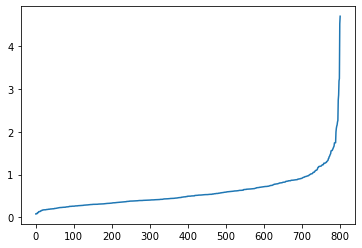

In [68]:
neighborslda = NearestNeighbors(n_neighbors=50)
neighborslda_fit = neighborslda.fit(df_dim_lda_tr)
distances, indices = neighborslda_fit.kneighbors(df_dim_lda_tr)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


In [69]:
entropies_dbscan_lda = []
for epsilon in np.arange(0.5,2,0.1):
    dbscanlda = DBSCAN(eps=epsilon,min_samples=50)
    clusterlabels_dbscan_lda = dbscanlda.fit_predict(df_dim_lda_tr)
    entropies_dbscan_lda.append((epsilon,entropy(clusterlabels_dbscan_lda, y_sup.values)[1]))

In [70]:
sorted(entropies_dbscan_lda, key = lambda x: x[1], reverse = False)[:5]

[(1.8999999999999997, 0.17199617723184366),
 (1.7999999999999998, 0.21720933645041815),
 (1.6999999999999997, 0.26868418361457674),
 (1.5999999999999996, 0.28919703991637624),
 (1.4999999999999998, 0.3445945347680846)]

In [71]:
dbscanlda = DBSCAN(eps=1.9,min_samples=50)
clusterlabels_dbscan_lda = dbscanlda.fit_predict(df_dim_lda_tr)
entropy(clusterlabels_dbscan_lda, y_sup.values)

({-1: 1.1110398222798932, 0: -0.0, 1: -0.0, 2: -0.0, 3: -0.0},
 0.17199617723184366)

Dbscan on LDA doesn't detect 5 clusters and treats many examples as rather outliers

## Analysis

Total 6 clustering algorithms were run:
1. KMeans clustering on Feature Selection Dataset : (Total entropy:0.0210, wrong clusters : 3 examples)
2. KMeans clustering on PCA dataset : (Total entropy : 0.03650, wrong clusters : 5 examples )
3. KMeans clustering on LDA dataset : (Total entropy: 0.00837, wrong clusters : 1 example)
4. DBSCAN clustering on Feature Selection Dataset : (Total entropy: 0.00173, wrong clusters : 2 examples)
5. DBSCAN clustering on PCA dataset : (Total entropy: 0.22706, wrong clusters : 150 )
6. DBSCAN clustering on LDA Dataset : (Total entropy : 0.17199, wrong clusters : Not applicable)


Entropy can be interpreted as following: If the entropy is 0 in a cluster, then it means all the examples assigned to the given cluster belong to the same class, else there are members of other classes as well. This gives us the top 3 clustering algorithms as follows : Kmeans on LDA Dataset, DBSCAN on Feature Selection Dataset, Kmeans on Feature Selection Dataset. 

**Samples of the same class which also belong to the same cluster** : Wherever entropy of a given cluster is 0, this condition is satisfied. 

**Samples identified to be belonging to another cluster but also to the same class (cancer type)** : This can be found out as follows: 


In [97]:
kmeansclusterlda.groupby('groundtruth').mean()

,kmeans
groundtruth,
0,0.000000
1,2.000000
2,4.000000
3,0.992647
4,3.000000


In [98]:
kmeansclusterlda[(kmeansclusterlda.groundtruth==3) & (kmeansclusterlda.kmeans!=1)]

,kmeans,groundtruth
243,0,3
